# LUNA - Nodule Detection



## Install Libraries

In [1]:
!pip install diskcache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 787.2 kB/s eta 0:00:00--:--


# Utils

In [2]:
import collections
import copy
import datetime
import gc
import time
import sys
import math

import numpy as np

In [3]:
IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

In [4]:
def importstr(module_str, from_=None):
    """
    >>> importstr('os')
    <module 'os' from '.../os.pyc'>
    >>> importstr('math', 'fabs')
    <built-in function fabs>
    """
    if from_ is None and ':' in module_str:
        module_str, from_ = module_str.rsplit(':')

    module = __import__(module_str)
    for sub_str in module_str.split('.')[1:]:
        module = getattr(module, sub_str)

    if from_:
        try:
            return getattr(module, from_)
        except:
            raise ImportError('{}.{}'.format(module_str, from_))
    return module

In [5]:
import logging
import logging.handlers

root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

# Some libraries attempt to add their own root logger handlers. This is
# annoying and so we get rid of them.
for handler in list(root_logger.handlers):
    root_logger.removeHandler(handler)

logfmt_str = "%(asctime)s %(levelname)-8s pid:%(process)d %(name)s:%(lineno)03d:%(funcName)s %(message)s"
formatter = logging.Formatter(logfmt_str)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(formatter)
streamHandler.setLevel(logging.DEBUG)

root_logger.addHandler(streamHandler)

In [6]:
log = logging.getLogger('nb')
log.setLevel(logging.DEBUG)

In [7]:
def enumerateWithEstimate(
        iter,
        desc_str,
        start_ndx=0,
        print_ndx=4,
        backoff=None,
        iter_len=None,
):
    """
    In terms of behavior, `enumerateWithEstimate` is almost identical
    to the standard `enumerate` (the differences are things like how
    our function returns a generator, while `enumerate` returns a
    specialized `<enumerate object at 0x...>`).

    However, the side effects (logging, specifically) are what make the
    function interesting.

    :param iter: `iter` is the iterable that will be passed into
        `enumerate`. Required.

    :param desc_str: This is a human-readable string that describes
        what the loop is doing. The value is arbitrary, but should be
        kept reasonably short. Things like `"epoch 4 training"` or
        `"deleting temp files"` or similar would all make sense.

    :param start_ndx: This parameter defines how many iterations of the
        loop should be skipped before timing actually starts. Skipping
        a few iterations can be useful if there are startup costs like
        caching that are only paid early on, resulting in a skewed
        average when those early iterations dominate the average time
        per iteration.

        NOTE: Using `start_ndx` to skip some iterations makes the time
        spent performing those iterations not be included in the
        displayed duration. Please account for this if you use the
        displayed duration for anything formal.

        This parameter defaults to `0`.

    :param print_ndx: determines which loop interation that the timing
        logging will start on. The intent is that we don't start
        logging until we've given the loop a few iterations to let the
        average time-per-iteration a chance to stablize a bit. We
        require that `print_ndx` not be less than `start_ndx` times
        `backoff`, since `start_ndx` greater than `0` implies that the
        early N iterations are unstable from a timing perspective.

        `print_ndx` defaults to `4`.

    :param backoff: This is used to how many iterations to skip before
        logging again. Frequent logging is less interesting later on,
        so by default we double the gap between logging messages each
        time after the first.

        `backoff` defaults to `2` unless iter_len is > 1000, in which
        case it defaults to `4`.

    :param iter_len: Since we need to know the number of items to
        estimate when the loop will finish, that can be provided by
        passing in a value for `iter_len`. If a value isn't provided,
        then it will be set by using the value of `len(iter)`.

    :return:
    """
    if iter_len is None:
        iter_len = len(iter)

    if backoff is None:
        backoff = 2
        while backoff ** 7 < iter_len:
            backoff *= 2

    assert backoff >= 2
    while print_ndx < start_ndx * backoff:
        print_ndx *= backoff

    log.warning("{} ----/{}, starting".format(
        desc_str,
        iter_len,
    ))
    start_ts = time.time()
    for (current_ndx, item) in enumerate(iter):
        yield (current_ndx, item)
        if current_ndx == print_ndx:
            # ... <1>
            duration_sec = ((time.time() - start_ts)
                            / (current_ndx - start_ndx + 1)
                            * (iter_len-start_ndx)
                            )

            done_dt = datetime.datetime.fromtimestamp(start_ts + duration_sec)
            done_td = datetime.timedelta(seconds=duration_sec)

            log.info("{} {:-4}/{}, done at {}, {}".format(
                desc_str,
                current_ndx,
                iter_len,
                str(done_dt).rsplit('.', 1)[0],
                str(done_td).rsplit('.', 1)[0],
            ))

            print_ndx *= backoff

        if current_ndx + 1 == start_ndx:
            start_ts = time.time()

    log.warning("{} ----/{}, done at {}".format(
        desc_str,
        iter_len,
        str(datetime.datetime.now()).rsplit('.', 1)[0],
    ))

# Disk

In [8]:
import gzip

from diskcache import FanoutCache, Disk
from diskcache.core import MODE_BINARY # delete BytesType and BytesIO declarations

BytesType = bytes # Import them by ourselves
import io
BytesIO = io.BytesIO

log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

In [9]:
class GzipDisk(Disk):
    def store(self, value, read, key=None):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param value: value to convert
        :param bool read: True when value is file-like object
        :return: (size, mode, filename, value) tuple for Cache table
        """
        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesType:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param int mode: value mode raw, binary, text, or pickle
        :param str filename: filename of corresponding value
        :param value: database value
        :param bool read: when True, return an open file handle
        :return: corresponding Python value
        """
        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value

def getCache(scope_str):
    return FanoutCache('cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       # disk_min_file_size=2**20,
                       )

# Visialize

In [10]:
import matplotlib
matplotlib.use('nbagg')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
clim=(-1000.0, 300)

def findPositiveSamples(start_ndx=0, limit=10):
    ds = LunaDataset(sortby_str='label_and_size')

    positiveSample_list = []
    for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
            # print(len(positiveSample_list), sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list

def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0

    ct = Ct(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')

# Datasets

### Import Libraries

In [12]:
import copy
import csv
import functools
import glob
import os
import random

from collections import namedtuple

import SimpleITK as sitk
import numpy as np

import torch
import torch.cuda
import torch.nn.functional as F
from torch.utils.data import Dataset

raw_cache = getCache('NodulDetect_raw')

# log = logging.getLogger(__name__)
# # log.setLevel(logging.WARN)
# # log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

In [13]:
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, diameter_mm, series_uid, center_xyz',
)

In [14]:
@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    mhd_list = glob.glob('/kaggle/input/luna16/subset[0-5]/subset*/*.mhd')
    presentOnDisk_set= {os.path.split(p)[-1][:-4] for p in mhd_list}
    
    diameter_dict = {}
    with open('/kaggle/input/luna16/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]: # skip title row
            series_id = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])
            
            diameter_dict.setdefault(series_id, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )
    
    list_limit = 30000
    cnt_limit = 0
    candidateInfo_list = []
    with open('/kaggle/input/luna16/candidates.csv', 'r') as f:
        # find all nodule
        for row in list(csv.reader(f))[1:]:
            series_id = row[0]
            
            if series_id not in presentOnDisk_set and requireOnDisk_bool:
                continue
            
            if cnt_limit > list_limit:
                break
            
            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])
            
            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_id, []):
                nnotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4: # shift over 1/4 is a different nodule data
                        break
                    else:
                        candidateDiameter_mm = annotationDiameter_mm
                        break
            if isNodule_bool:
                candidateInfo_list.append(CandidateInfoTuple(
                    isNodule_bool,
                    candidateDiameter_mm,
                    series_id,
                    candidateCenter_xyz,
                ))
                cnt_limit += 1
                
        # find not nodule
        f.seek(0)
        for row in list(csv.reader(f))[1:]:
            series_id = row[0]
            
            if series_id not in presentOnDisk_set and requireOnDisk_bool:
                continue
                
            if cnt_limit > list_limit:
                break
            
            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])
            
            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_id, []):
                nnotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4: # shift over 1/4 is a different nodule data
                        break
                    else:
                        candidateDiameter_mm = annotationDiameter_mm
                        break
            if not isNodule_bool:
                candidateInfo_list.append(CandidateInfoTuple(
                    isNodule_bool,
                    candidateDiameter_mm,
                    series_id,
                    candidateCenter_xyz,
                ))
                cnt_limit += 1
        
            
    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

In [15]:
def getCtAugmentedCandidate(augmentation_dict, series_uid, center_xyz, width_irc, use_cache=True):
    if use_cache:
        ct_chunk, center_irc = getCtRawCandidate(series_uid, center_xyz, width_irc)
    else:
        ct = getCt(series_uid)
        ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)

    ct_t = torch.tensor(ct_chunk).unsqueeze(0).unsqueeze(0).to(torch.float32)

    transform_t = torch.eye(4)

    for i in range(3):
        if 'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1

        if 'offset' in augmentation_dict:
            offset_float = augmentation_dict['offset']
            random_float = (random.random() * 2 - 1)
            transform_t[i,3] = offset_float * random_float

        if 'scale' in augmentation_dict:
            scale_float = augmentation_dict['scale']
            random_float = (random.random() * 2 - 1)
            transform_t[i,i] *= 1.0 + scale_float * random_float


    if 'rotate' in augmentation_dict:
        angle_rad = random.random() * math.pi * 2
        s = math.sin(angle_rad)
        c = math.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

        transform_t @= rotation_t

    affine_t = F.affine_grid(
            transform_t[:3].unsqueeze(0).to(torch.float32),
            ct_t.size(),
            align_corners=False,
        )

    augmented_chunk = F.grid_sample(
            ct_t,
            affine_t,
            padding_mode='border',
            align_corners=False,
        ).to('cpu')

    if 'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t

    return augmented_chunk[0], center_irc

In [16]:
class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob('/kaggle/input/luna16/subset[0-5]/subset*/{}.mhd'.format(series_uid))[0]
        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
        
        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down
        ct_a.clip(-1000,1000, ct_a)
        
        self.series_uid = series_uid
        self.hu_a = ct_a
        
        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)
        
    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz, 
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )
        
        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])
            
            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])
            
            if start_ndx < 0:
                start_ndx = 0
                end_ndx = int(width_irc[axis])
            
            if end_ndx > self.hu_a.shape[axis]:
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])
            
            slice_list.append(slice(start_ndx, end_ndx))
            
        ct_chunk = self.hu_a[tuple(slice_list)]
        
        return ct_chunk, center_irc

In [17]:
@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

### Create Dataset

In [18]:
class LunaDataset(Dataset):
    def __init__(self, val_stride=10, isValSet_bool=None, series_uid=None, sortby_str='random', ratio_int=0,
                 augmentation_dict=None, candidateInfo_list=None):
        
        self.ratio_int = ratio_int
        self.augmentation_dict = augmentation_dict
        
        if candidateInfo_list:
            self.candidateInfo_list = copy.copy(candidateInfo_list)
            self.use_cache = False
        else:
            self.candidateInfo_list = copy.copy(getCandidateInfoList())
            self.use_cache = True
            
        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]
            
        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
            
        if sortby_str == 'random':
            random.shuffle(self.candidateInfo_list)
        elif sortby_str == 'series_uid':
            self.candidateInfo_list.sort(key=lambda x: (x.series_uid, x.center_xyz))
        elif sortby_str == 'label_and_size':
            pass
        else:
            raise Exception("Unknown sort: " + repr(sortby_str))

        self.negative_list = [
            nt for nt in self.candidateInfo_list if not nt.isNodule_bool
        ]
        self.pos_list = [
            nt for nt in self.candidateInfo_list if nt.isNodule_bool
        ]
        
        log.info("{!r}: {} {} samples, {} neg, {} pos, {} ratio".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
            len(self.negative_list),
            len(self.pos_list),
            '{}:1'.format(self.ratio_int) if self.ratio_int else 'unbalanced'
        ))
        
    def shuffleSamples(self):
        if self.ratio_int:
            random.shuffle(self.negative_list)
            random.shuffle(self.pos_list)

    def __len__(self):
        if self.ratio_int:
            return 200000
        else:
            return len(self.candidateInfo_list)
    
    def __getitem__(self, ndx):
        if self.ratio_int:
            pos_ndx = ndx // (self.ratio_int + 1)

            if ndx % (self.ratio_int + 1):
                neg_ndx = ndx - 1 - pos_ndx
                neg_ndx %= len(self.negative_list)
                candidateInfo_tup = self.negative_list[neg_ndx]
            else:
                pos_ndx %= len(self.pos_list)
                candidateInfo_tup = self.pos_list[pos_ndx]
        else:
            candidateInfo_tup = self.candidateInfo_list[ndx]
            
        width_irc = (32,48,48)
        
        if self.augmentation_dict:
            candidate_t, center_irc = getCtAugmentedCandidate(
                self.augmentation_dict,
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
                self.use_cache,
            )
        elif self.use_cache:
            candidate_a, center_irc = getCtRawCandidate(
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)
        else:
            ct = getCt(candidateInfo_tup.series_uid)
            candidate_a, center_irc = ct.getRawCandidate(
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )

        return candidate_t, pos_t, candidateInfo_tup.series_uid, torch.tensor(center_irc)

## Nodule Sample

In [19]:
dataset = LunaDataset(sortby_str='label_and_size')

2024-07-04 09:18:07,656 INFO     pid:34 __main__:044:__init__ <__main__.LunaDataset object at 0x7c3539d38c70>: 27000 training samples, 26251 neg, 749 pos, unbalanced ratio


In [20]:
len(dataset.negative_list), len(dataset.pos_list)

(26251, 749)

2024-07-04 09:18:19,878 INFO     pid:34 __main__:044:__init__ <__main__.LunaDataset object at 0x7c348692ebc0>: 27000 training samples, 26251 neg, 749 pos, unbalanced ratio
2024-07-04 09:18:19,883 INFO     pid:34 __main__:044:__init__ <__main__.LunaDataset object at 0x7c3539eb1780>: 541 training samples, 532 neg, 9 pos, unbalanced ratio


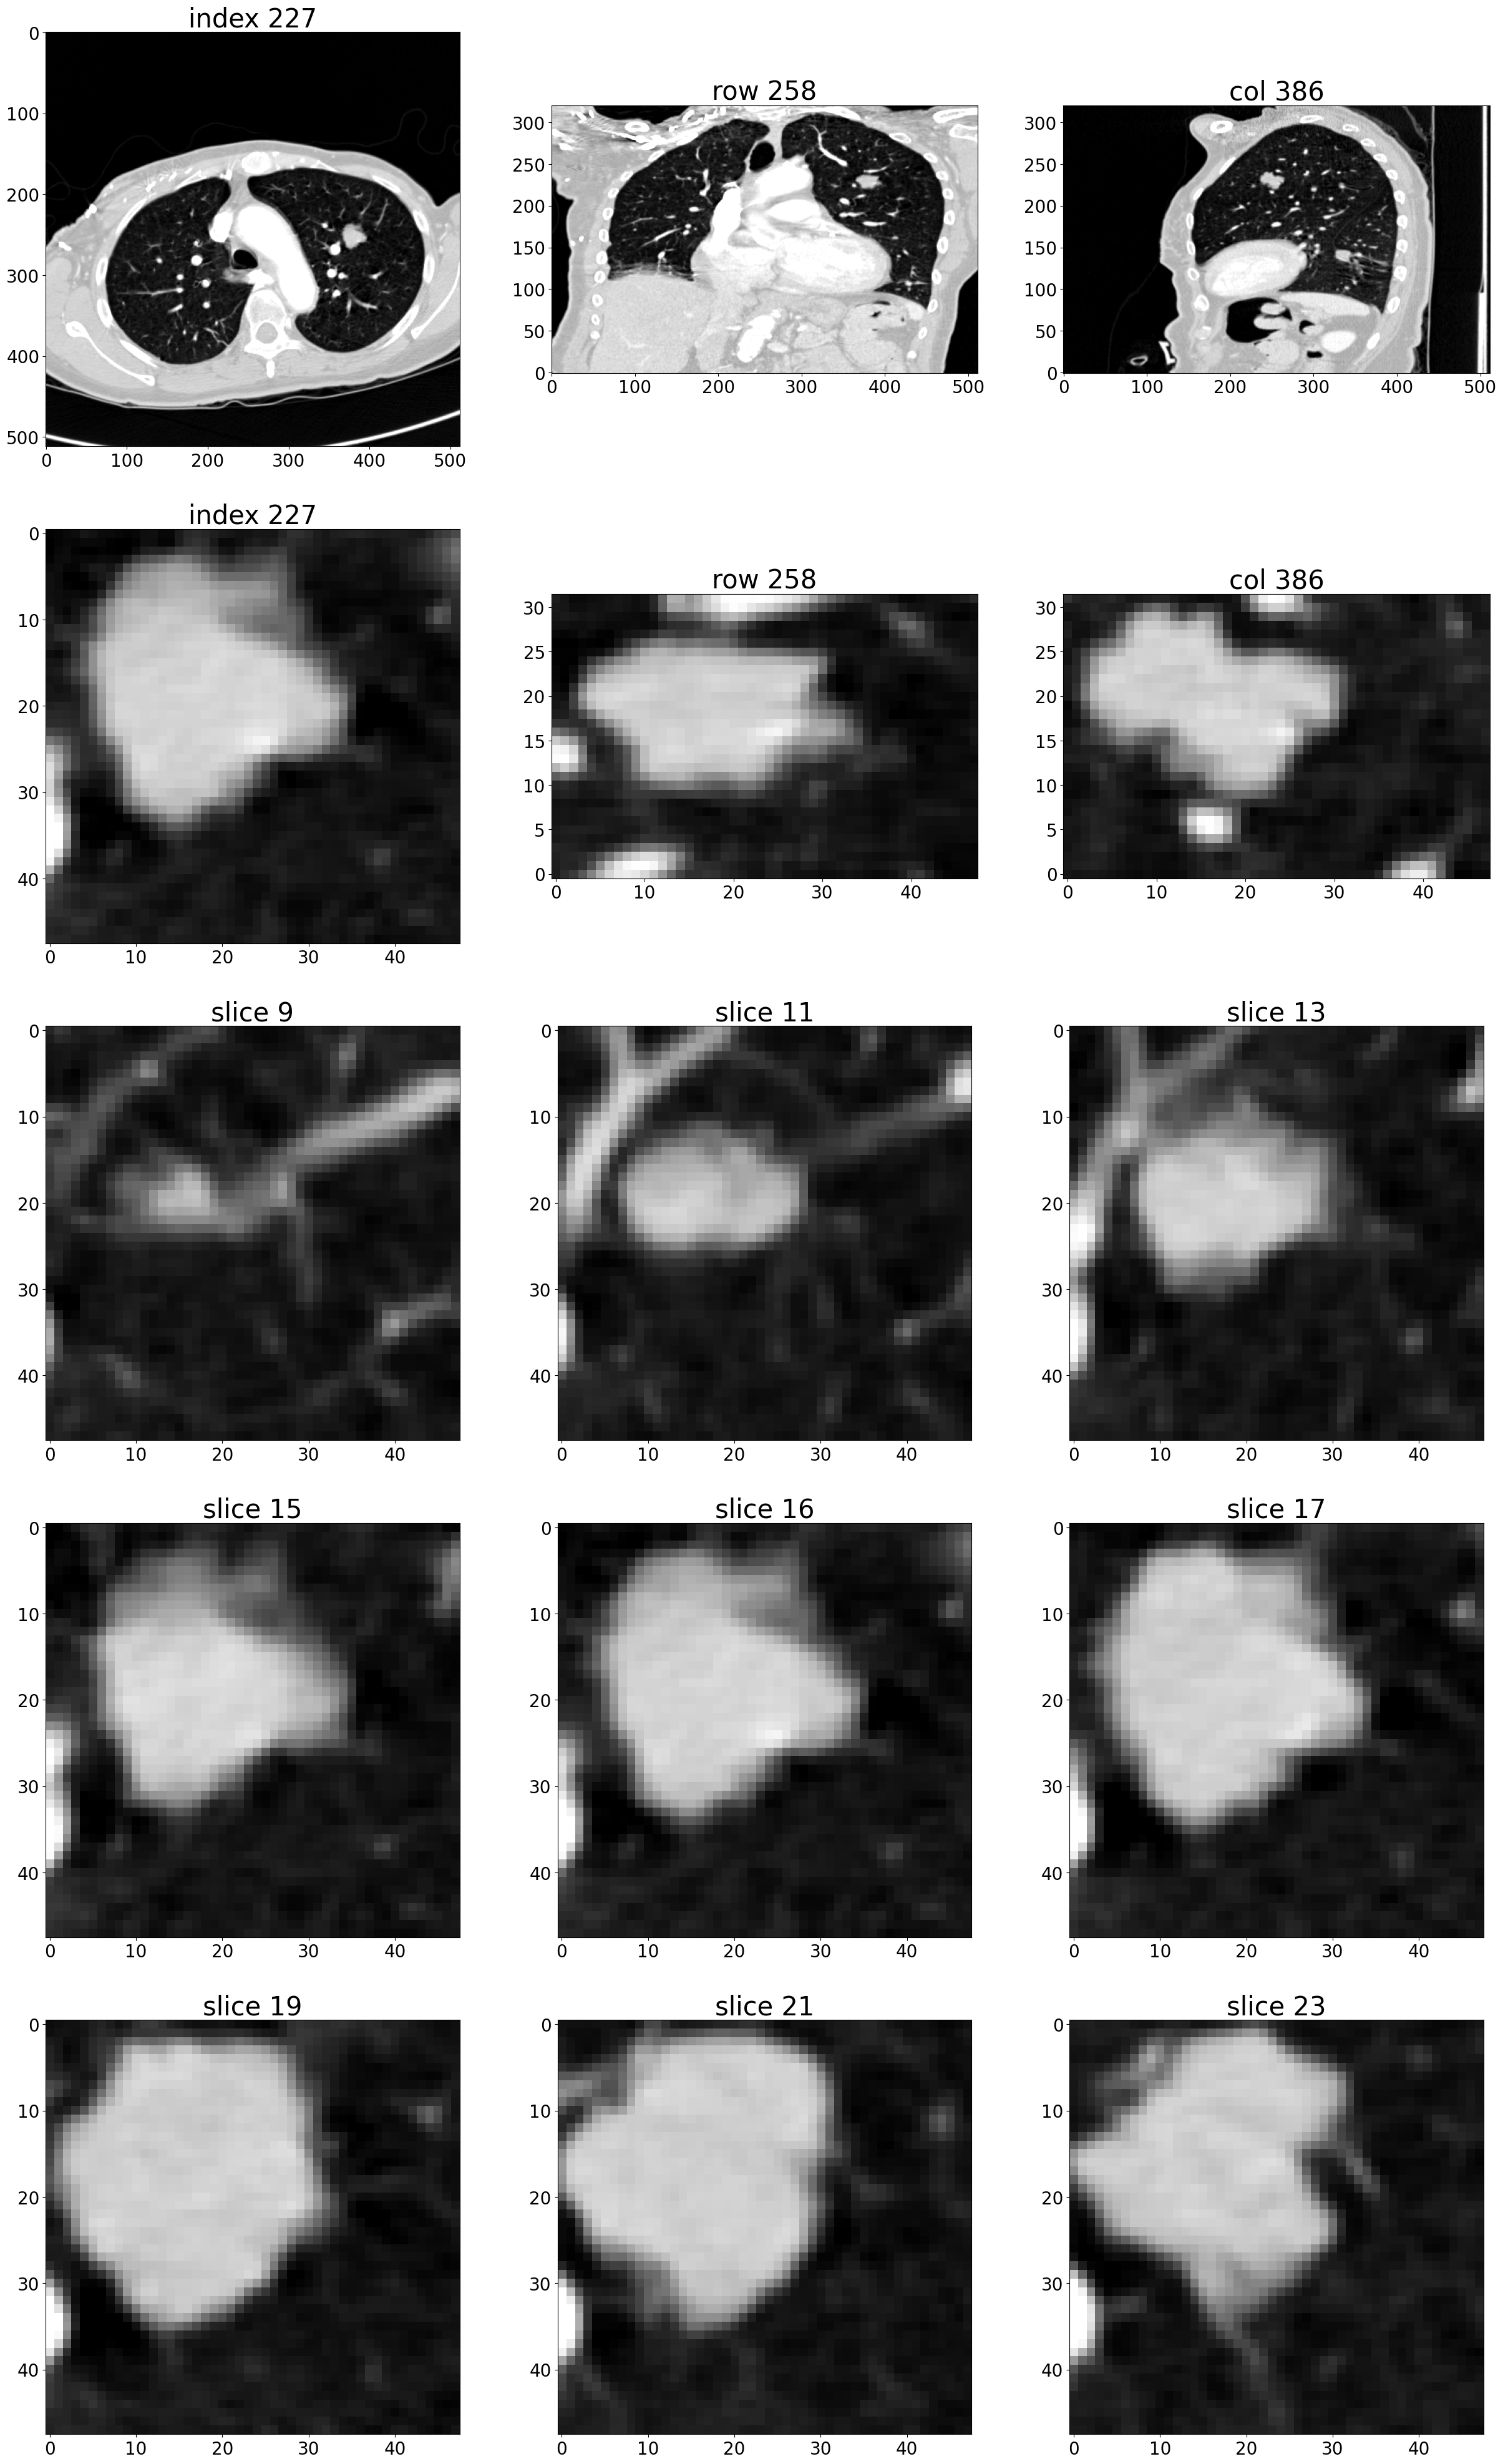

In [21]:
positiveSample_list = findPositiveSamples()
series_uid = positiveSample_list[0][2]
showCandidate(series_uid, sortby_str='label_and_size')

# Model

In [22]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

In [23]:
class LunaBlock(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super().__init__()
        
        self.conv1 = nn.Conv3d(in_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(conv_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(2, 2)
        
    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.relu2(block_out) 
        
        return self.maxpool(block_out)

In [24]:
class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=8):
        super().__init__()
        
        # tail
        self.tail_batchnorm = nn.BatchNorm3d(1)
        
        # body
        self.block1 = LunaBlock(in_channels, conv_channels)
        self.block2 = LunaBlock(conv_channels, conv_channels * 2)
        self.block3 = LunaBlock(conv_channels * 2, conv_channels * 4)
        self.block4 = LunaBlock(conv_channels * 4, conv_channels * 8)
        
        # head
        self.head_linear = nn.Linear(1152, 2)
        self.head_softmax = nn.Softmax(dim=1)
        
        self._init_weights()
    
    def forward(self, input_batch):
        bn_output = self.tail_batchnorm(input_batch)
        
        block_output = self.block1(bn_output)
        block_output = self.block2(block_output)
        block_output = self.block3(block_output)
        block_output = self.block4(block_output)
        
        conv_flat = block_output.view(block_output.size(0), -1)
        
        linear_output = self.head_linear(conv_flat)
        return linear_output, self.head_softmax(linear_output)
    
    # see also https://github.com/pytorch/pytorch/issues/18182
    def _init_weights(self):
        for m in self.modules():
            if type(m) in {
                nn.Linear,
                nn.Conv3d,
                nn.Conv2d,
                nn.ConvTranspose2d,
                nn.ConvTranspose3d,
            }:
                nn.init.kaiming_normal_(
                    m.weight.data, a=0, mode='fan_out', nonlinearity='relu',
                )
                if m.bias is not None:
                    fan_in, fan_out = \
                        nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                    bound = 1 / math.sqrt(fan_out)
                    nn.init.normal_(m.bias, -bound, bound)
        

# Training

In [25]:
import argparse
import os
import shutil

from torch.utils.tensorboard import SummaryWriter

METRICS_SIZE = 10

METRICS_LABEL_NDX=0
METRICS_PRED_NDX=1
METRICS_LOSS_NDX=2
METRICS_SIZE = 3

2024-07-04 09:18:44.906309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 09:18:44.906404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 09:18:45.005468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 09:18:53,393 INFO     pid:34 numexpr.utils:161:_init_num_threads NumExpr defaulting to 4 threads.


In [40]:
class LunaTrainingApp:
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:]
        
        parser = argparse.ArgumentParser()
        parser.add_argument('--num-workers',
            help='Number of worker processes for background data loading',
            default=4,
            type=int,
        )
        
        parser.add_argument('--batch-size',
            help='Batch size to use for training',
            default=32,
            type=int,
        )
        parser.add_argument('--epochs',
            help='Number of epochs to train for',
            default=1,
            type=int,
        )
        parser.add_argument('--balanced',
            help="Balance the training data to half positive, half negative.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augmented',
            help="Augment the training data.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-flip',
            help="Augment the training data by randomly flipping the data left-right, up-down, and front-back.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-offset',
            help="Augment the training data by randomly offsetting the data slightly along the X and Y axes.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-scale',
            help="Augment the training data by randomly increasing or decreasing the size of the candidate.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-rotate',
            help="Augment the training data by randomly rotating the data around the head-foot axis.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--augment-noise',
            help="Augment the training data by randomly adding noise to the data.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--tb-prefix',
            default='ND',
            help="Data prefix to use for Tensorboard run. Defaults to chapter.",
        )

        parser.add_argument('comment',
            help="Comment suffix for Tensorboard run.",
            nargs='?',
            default='dwlpt',
        )
        
        self.cli_args = parser.parse_args(sys_argv)
        self.time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
        
        self.trn_writer = None
        self.val_writer = None
        self.totalTrainingSamples_count = 0
        
        self.augmentation_dict = {}
        if self.cli_args.augmented or self.cli_args.augment_flip:
            self.augmentation_dict['flip'] = True
        if self.cli_args.augmented or self.cli_args.augment_offset:
            self.augmentation_dict['offset'] = 0.1
        if self.cli_args.augmented or self.cli_args.augment_scale:
            self.augmentation_dict['scale'] = 0.2
        if self.cli_args.augmented or self.cli_args.augment_rotate:
            self.augmentation_dict['rotate'] = True
#         if self.cli_args.augmented or self.cli_args.augment_noise:
#             self.augmentation_dict['noise'] = 25.0
        
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        
        self.model = self.initModel()
        self.optimizer = self.initOptimizer()
        
    def initModel(self):
        model = LunaModel()
        if self.use_cuda:
            log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
            model = model.to(self.device)
        return model
        
    def initOptimizer(self):
        return SGD(self.model.parameters(), lr=0.001, momentum=0.99)
    
    def initTrainDl(self):
        train_ds = LunaDataset(val_stride=10, isValSet_bool=False,
            ratio_int=int(self.cli_args.balanced),
            augmentation_dict=self.augmentation_dict,)
        
        batch_size = self.cli_args.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()
        
        train_dl = DataLoader(
            train_ds, batch_size=batch_size,
            num_workers=self.cli_args.num_workers, pin_memory=self.use_cuda,
        )
        
        return train_dl
    
    def initValDl(self):
        val_ds = LunaDataset(val_stride=10, isValSet_bool=True)
        
        batch_size = self.cli_args.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()
        
        val_dl = DataLoader(
            val_ds, batch_size=batch_size,
            num_workers=self.cli_args.num_workers, pin_memory=self.use_cuda,
        )
        
        return val_dl
    
    def main(self):
        log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))
        
        train_dl = self.initTrainDl()
        val_dl = self.initValDl()
        
        best_score = 0.0
        self.validation_cadence = 5
        for epoch_ndx in range(1, self.cli_args.epochs + 1):
            log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
                epoch_ndx, self.cli_args.epochs, len(train_dl), len(val_dl),
                self.cli_args.batch_size,
                (torch.cuda.device_count() if self.use_cuda else 1),
            ))
            
            trnMetrics_t = self.doTraining(epoch_ndx, train_dl)
            self.logMetrics(epoch_ndx, 'trn', trnMetrics_t)
            
            self.seveModel(epoch_ndx, 'Nodule_Detect_model_last.pth')
            
            valMetrics_t = self.doValidation(epoch_ndx, val_dl)
            self.logMetrics(epoch_ndx, 'val', valMetrics_t)
        
    def doTraining(self, epoch_ndx, train_dl):
        self.model.train()
        train_dl.dataset.shuffleSamples()
        trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=self.device)
        
        batch_iter = enumerateWithEstimate(
            train_dl,
            "E{} Training".format(epoch_ndx),
            start_ndx=train_dl.num_workers,
        )
        
        for batch_ndx, batch_tup in batch_iter:
            self.optimizer.zero_grad()
            
            loss_var = self.computeBatchLoss(
                batch_ndx,
                batch_tup,
                train_dl.batch_size,
                trnMetrics_g
            )
            
            loss_var.backward()
            self.optimizer.step()
            
        self.totalTrainingSamples_count += len(train_dl.dataset)
        
        return trnMetrics_g.to('cpu')
    
    def doValidation(self, epoch_ndx, val_dl):
        with torch.no_grad():
            self.model.eval()
            valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=self.device)

            batch_iter = enumerateWithEstimate(
                val_dl,
                "E{} Validation".format(epoch_ndx),
                start_ndx=val_dl.num_workers,
            )

            for batch_ndx, batch_tup in batch_iter:
                loss_var = self.computeBatchLoss(
                    batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

            return valMetrics_g.to('cpu')
    
    def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g):
        input_t, label_t, _series_list, _center_list = batch_tup
        
        input_g = input_t.to(self.device, non_blocking=True)
        label_g = label_t.to(self.device, non_blocking=True)
        
        logits_g, probability_g = self.model(input_g)
        
        loss_func = nn.CrossEntropyLoss(reduction='none')
        loss_g = loss_func(logits_g, label_g[:,1])
        
        start_ndx = batch_ndx * batch_size
        end_ndx = start_ndx + label_t.size(0)
        
        metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = label_g[:,1].detach()
        metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = probability_g[:,1].detach()
        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = loss_g.detach()
        
        return loss_g.mean()
        
    def logMetrics(self, epoch_ndx, mode_str, metrics_t, classificationThreshold=0.5):
        self.initTensorboardWriters()
        log.info("E{} {}".format(epoch_ndx, type(self).__name__))
        
        negLabel_mask = metrics_t[METRICS_LABEL_NDX] <= classificationThreshold
        negPred_mask = metrics_t[METRICS_PRED_NDX] <= classificationThreshold
        
        posLabel_mask = ~negLabel_mask
        posPred_mask = ~negPred_mask
        
        neg_count = int(negLabel_mask.sum())
        pos_count = int(posLabel_mask.sum())
        
        neg_correct = int((negLabel_mask & negPred_mask).sum())
        pos_correct = int((posLabel_mask & posPred_mask).sum())
        
        trueNeg_count = neg_correct = int((negLabel_mask & negPred_mask).sum())
        truePos_count = pos_correct = int((posLabel_mask & posPred_mask).sum())

        falsePos_count = neg_count - neg_correct
        falseNeg_count = pos_count - pos_correct
        
        metrics_dict = {}
        metrics_dict['loss/all'] = metrics_t[METRICS_LOSS_NDX].mean()
        metrics_dict['loss/neg'] = metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean()
        metrics_dict['loss/pos'] = metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean()
        
        metrics_dict['correct/all'] = (pos_correct + neg_correct) / np.float32(metrics_t.shape[1]) * 100
        metrics_dict['correct/neg'] = (neg_correct) / np.float32(neg_count) * 100
        metrics_dict['correct/pos'] = (pos_correct) / np.float32(pos_count) * 100
        
        precision = metrics_dict['pr/precision'] = truePos_count / np.float32(truePos_count + falsePos_count)
        recall = metrics_dict['pr/recall'] = truePos_count / np.float32(truePos_count + falseNeg_count)
        
        metrics_dict['pr/f1_score'] = 2 * (precision * recall) / (precision + recall)
        
        log.info(
            ("E{} {:8} {loss/all:.4f} loss, "
                 + "{correct/all:-5.1f}% correct, "
                 + "{pr/precision:.4f} precision, "
                 + "{pr/recall:.4f} recall, "
                 + "{pr/f1_score:.4f} f1 score"
            ).format(
                epoch_ndx,
                mode_str,
                **metrics_dict,
            )
        )
        log.info(
            ("E{} {:8} {loss/neg:.4f} loss, "
                 + "{correct/neg:-5.1f}% correct ({neg_correct:} of {neg_count:})"
            ).format(
                epoch_ndx,
                mode_str + '_neg',
                neg_correct=neg_correct,
                neg_count=neg_count,
                **metrics_dict,
            )
        )
        log.info(
            ("E{} {:8} {loss/pos:.4f} loss, "
                 + "{correct/pos:-5.1f}% correct ({pos_correct:} of {pos_count:})"
            ).format(
                epoch_ndx,
                mode_str + '_pos',
                pos_correct=pos_correct,
                pos_count=pos_count,
                **metrics_dict,
            )
        )
        
        writer = getattr(self, mode_str + '_writer')

        for key, value in metrics_dict.items():
            writer.add_scalar(key, value, self.totalTrainingSamples_count)

        writer.add_pr_curve(
            'pr',
            metrics_t[METRICS_LABEL_NDX],
            metrics_t[METRICS_PRED_NDX],
            self.totalTrainingSamples_count,
        )

        bins = [x/50.0 for x in range(51)]

        negHist_mask = negLabel_mask & (metrics_t[METRICS_PRED_NDX] > 0.01)
        posHist_mask = posLabel_mask & (metrics_t[METRICS_PRED_NDX] < 0.99)

        if negHist_mask.any():
            writer.add_histogram(
                'is_neg',
                metrics_t[METRICS_PRED_NDX, negHist_mask],
                self.totalTrainingSamples_count,
                bins=bins,
            )
        if posHist_mask.any():
            writer.add_histogram(
                'is_pos',
                metrics_t[METRICS_PRED_NDX, posHist_mask],
                self.totalTrainingSamples_count,
                bins=bins,
            )
        
        
    def initTensorboardWriters(self):
        if self.trn_writer is None:
            log_dir = os.path.join('runs', self.cli_args.tb_prefix, self.time_str)

            self.trn_writer = SummaryWriter(
                log_dir=log_dir + '-trn_cls-' + self.cli_args.comment)
            self.val_writer = SummaryWriter(
                log_dir=log_dir + '-val_cls-' + self.cli_args.comment)
            
    def seveModel(self, epoch_ndx, path):
        if isinstance(self.model, torch.nn.DataParallel):
            self.model = self.model.module

        state = {
            'time': str(datetime.datetime.now()),
            'model_state': self.model.state_dict(),
            'model_name': type(self.model).__name__,
            'epoch_num': epoch_ndx
        }
        
        torch.save(state, path)
        
    
    def loadModel(self, path):
        state_dict = torch.load(path)
        
        self.model = LunaModel()
        
        self.model.load_state_dict(state_dict['model_state'])

        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(device)

        

# Prepare Catch

In [47]:
class LunaPrepCacheApp:
    @classmethod
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:]

    def main(self):
        log.info("Starting {}".format(type(self).__name__))

        self.prep_dl = DataLoader(
            LunaDataset(
                sortby_str='series_uid',
            ),
            batch_size=1024,
            num_workers=4,
        )

        batch_iter = enumerateWithEstimate(
            self.prep_dl,
            "Stuffing cache",
            start_ndx=4,
        )
        
        for _ in batch_iter:
            pass
        
        self.prep2_dl = DataLoader(
            LunaDataset(
                sortby_str='series_uid', 
                isValSet_bool=True
            ),
            batch_size=1024,
            num_workers=4               
        )

        batch_iter = enumerateWithEstimate(
            self.prep2_dl,
            "Stuffing cache",
            start_ndx=4,
        )
        
        for _ in batch_iter:
            pass

In [48]:
pre = LunaPrepCacheApp()

In [49]:
pre.main()

2024-07-04 09:53:16,255 INFO     pid:34 __main__:008:main Starting LunaPrepCacheApp
2024-07-04 09:53:16,743 INFO     pid:34 __main__:044:__init__ <__main__.LunaDataset object at 0x7c3482af4490>: 27000 training samples, 26251 neg, 749 pos, unbalanced ratio
2024-07-04 09:53:16,744 WARNING  pid:34 __main__:081:enumerateWithEstimate Stuffing cache ----/27, starting
2024-07-04 09:53:21,144 INFO     pid:34 __main__:098:enumerateWithEstimate Stuffing cache    8/27, done at 2024-07-04 09:53:30, 0:00:11
2024-07-04 09:53:24,007 INFO     pid:34 __main__:098:enumerateWithEstimate Stuffing cache   16/27, done at 2024-07-04 09:53:28, 0:00:09
2024-07-04 09:53:26,502 WARNING  pid:34 __main__:111:enumerateWithEstimate Stuffing cache ----/27, done at 2024-07-04 09:53:26
2024-07-04 09:53:26,510 INFO     pid:34 __main__:044:__init__ <__main__.LunaDataset object at 0x7c347e01b310>: 3001 validation samples, 2917 neg, 84 pos, unbalanced ratio
2024-07-04 09:53:26,511 WARNING  pid:34 __main__:081:enumerateWith

# Start Training

In [50]:
app = LunaTrainingApp(['--epochs', '10', '--balanced', '--augmented'])
# app = LunaTrainingApp(['--epochs', '1'])

2024-07-04 09:53:38,298 INFO     pid:34 __main__:097:initModel Using CUDA; 2 devices.


In [51]:
app.device

device(type='cuda')

In [52]:
app.main()

2024-07-04 09:53:41,455 INFO     pid:34 __main__:137:main Starting LunaTrainingApp, Namespace(num_workers=4, batch_size=32, epochs=10, balanced=True, augmented=True, augment_flip=False, augment_offset=False, augment_scale=False, augment_rotate=False, augment_noise=False, tb_prefix='ND', comment='dwlpt')
2024-07-04 09:53:41,490 INFO     pid:34 __main__:044:__init__ <__main__.LunaDataset object at 0x7c347e018ca0>: 27000 training samples, 26251 neg, 749 pos, 1:1 ratio
2024-07-04 09:53:41,494 INFO     pid:34 __main__:044:__init__ <__main__.LunaDataset object at 0x7c347e01b670>: 3001 validation samples, 2917 neg, 84 pos, unbalanced ratio
2024-07-04 09:53:41,495 INFO     pid:34 __main__:145:main Epoch 1 of 10, 3125/47 batches of size 32*2
2024-07-04 09:53:41,523 WARNING  pid:34 __main__:081:enumerateWithEstimate E1 Training ----/3125, starting
2024-07-04 09:53:45,190 INFO     pid:34 __main__:098:enumerateWithEstimate E1 Training   16/3125, done at 2024-07-04 10:03:38, 0:09:55
2024-07-04 09:5

In [ ]:
model = app.model
if isinstance(model, torch.nn.DataParallel):
    model = model.module

state = {
    'time': str(datetime.datetime.now()),
    'model_state': model.state_dict(),
    'model_name': type(model).__name__,
    'epoch': 1,
}


In [ ]:
torch.save(state, "Nodule_Detect_model_last.pth")